https://tcoil.info/detect-double-top-in-stocks-with-python/

In [3]:
#!pip3 install fix_yahoo_finance
#!pip3 install pandas_datareader

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

#yahoo API data source correction
#import fix_yahoo_finance as yahoo_finance
import yfinance as yahoo_finance
yahoo_finance.pdr_override()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# ___variables___
ticker = 'VZ'
start_time = datetime.datetime(2017, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [5]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

[*********************100%***********************]  1 of 1 completed
connected to yahoo
        Date       Open       High        Low      Close  Adj Close    Volume
0 2017-10-02  49.389999  49.700001  49.250000  49.360001  41.431995   9525800
1 2017-10-03  49.450001  50.020000  49.430000  49.849998  41.843292  10218600
2 2017-10-04  49.639999  50.080002  49.380001  49.900002  41.885265   9887500
3 2017-10-05  49.959999  50.029999  49.680000  49.770000  41.776142  12230600
4 2017-10-06  49.040001  49.200001  48.660000  48.810001  41.461845  13239600


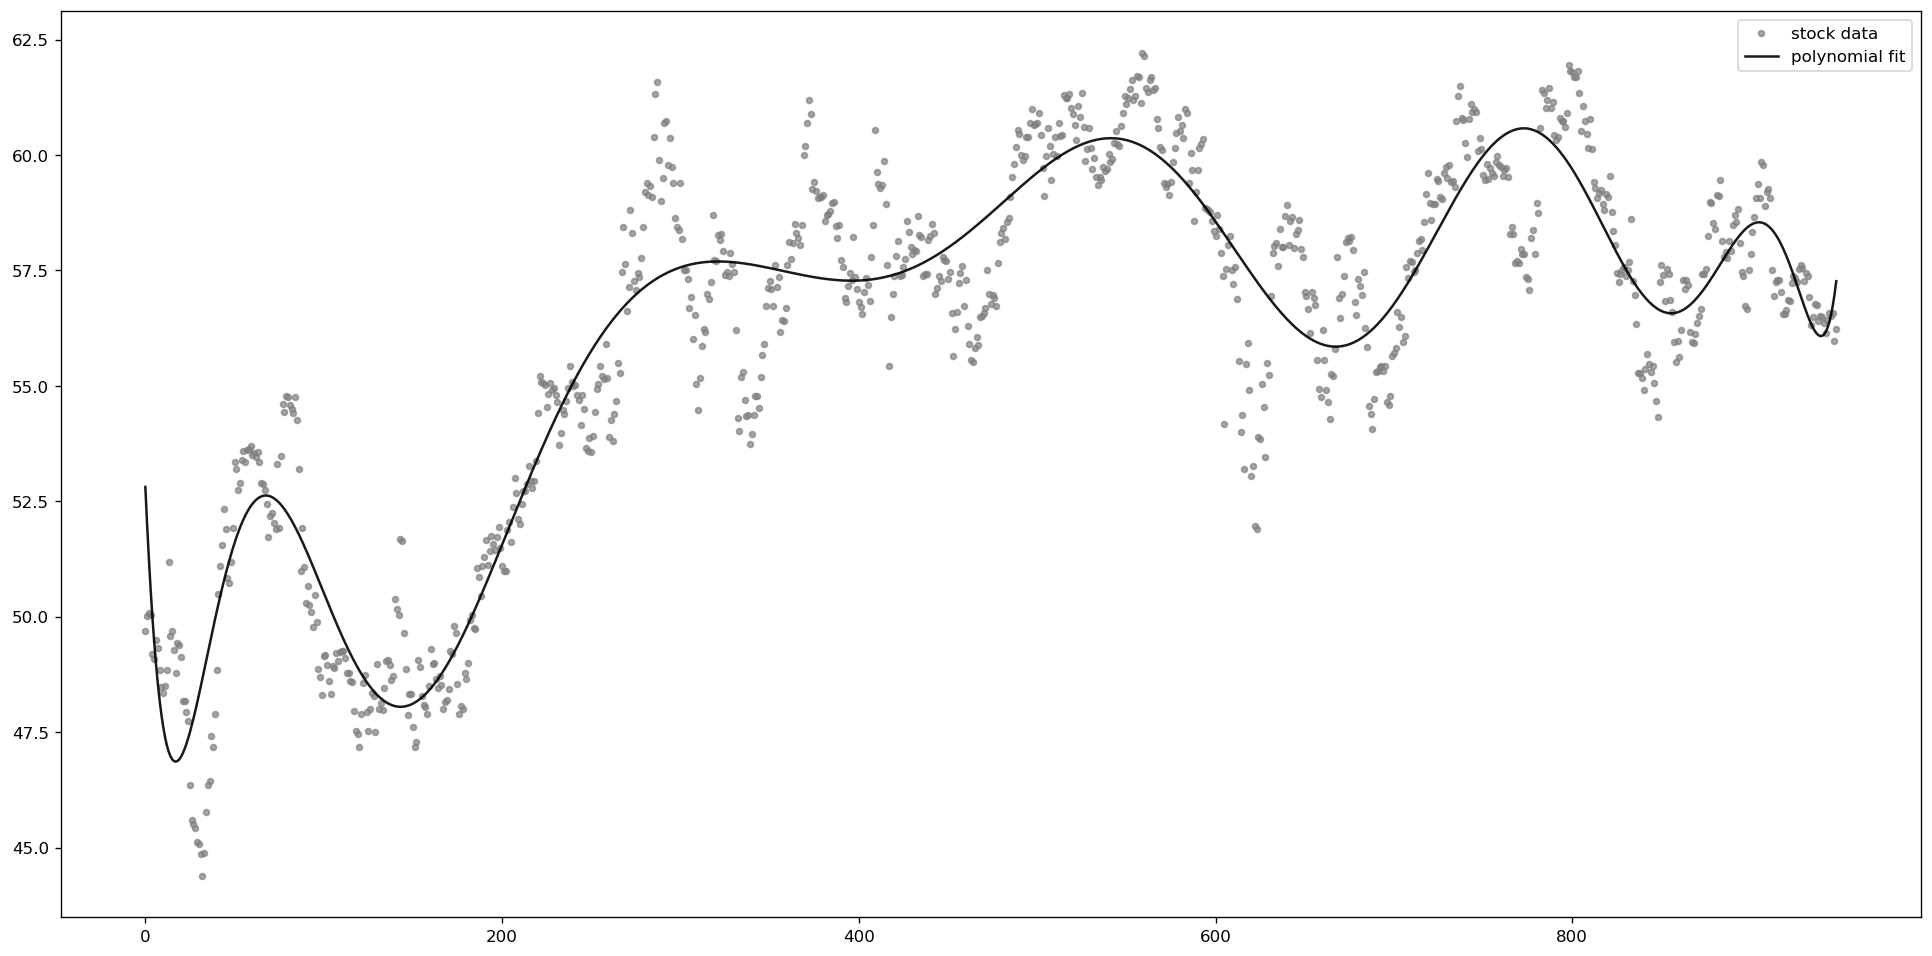

In [6]:
# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date
y_data = ticker_df['High']

# x values for the polynomial fit, 200 points
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# polynomial fit of degree xxx
pol = np.polyfit(x_data, y_data, 15)
y_pol = np.polyval(pol, x)

# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=3.5, color='grey', alpha=0.7)
# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

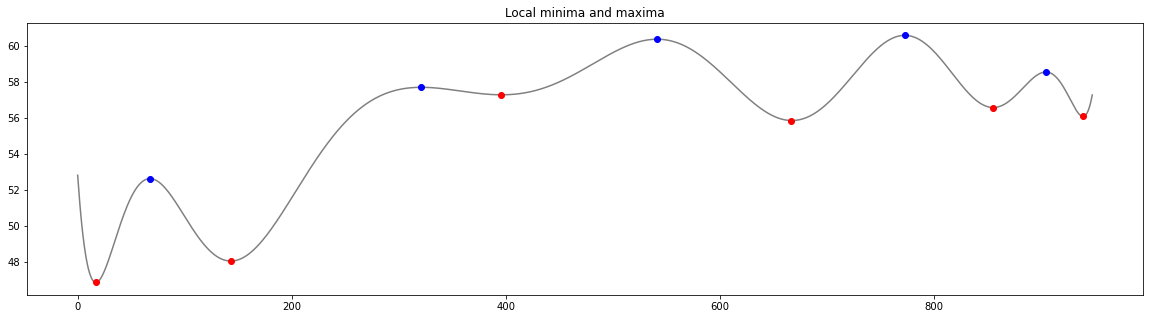

In [7]:
data = y_pol

#                         ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(20, 5))
plt.plot(x, data, color='grey')
plt.plot(x[l_min], data[l_min], "o", label="min", color='r')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='b')        # maxima
plt.title('Local minima and maxima')
plt.show()

In [8]:
print('corresponding HIGH values for suspected indices: ')
print(ticker_df.High.iloc[l_max])

#extend the suspected x range:
delta = 5                                        # how many ticks to the left and to the right from local maximum on x axis

dict_i = dict()

for element in l_max:
    l_bound = element - delta                    # lower bound
    u_bound = element + delta                    # upper bound
    x_range = range(l_bound, u_bound + 1)

    y_loc_list = list()
    for x_element in x_range:
        y_loc_list.append(ticker_df.High.iloc[x_element]) 
        #print(y_loc_list)   
    dict_i[element] = y_loc_list
print('DICTIONARY for l_max: ', dict_i)

corresponding HIGH values for suspected indices: 
68     52.439999
321    58.259998
541    59.849998
773    57.849998
905    59.070000
Name: High, dtype: float64
DICTIONARY for l_max:  {68: [53.56999969482422, 53.34000015258789, 52.88999938964844, 52.880001068115234, 52.75, 52.439998626708984, 51.72999954223633, 52.18000030517578, 52.2400016784668, 52.02000045776367, 51.900001525878906], 321: [56.88999938964844, 57.2599983215332, 58.689998626708984, 57.720001220703125, 57.70000076293945, 58.2599983215332, 58.150001525878906, 58.290000915527344, 57.93000030517578, 57.400001525878906, 57.470001220703125], 541: [59.459999084472656, 59.75, 59.65999984741211, 59.689998626708984, 60.029998779296875, 59.849998474121094, 59.90999984741211, 60.27000045776367, 60.529998779296875, 60.22999954223633, 60.20000076293945], 773: [57.66999816894531, 57.709999084472656, 57.65999984741211, 57.970001220703125, 57.849998474121094, 57.849998474121094, 57.349998474121094, 57.310001373291016, 57.0699996948242

In [9]:
y_delta = 0.05                              # percentage distance between average highs
threshold = max(ticker_df['High']) * 0.90   # setting threshold lower than the global high

y_dict = dict()
maxi = list()
suspected_tops = list()

for key in dict_i.keys():
    mn = sum(dict_i[key])/len(dict_i[key])
    maxi.append(max(dict_i[key]))
    l_y = mn * (1.0 - y_delta)
    u_y = mn * (1.0 + y_delta)
    y_dict[key] = [l_y, u_y, mn]

print('SCREENING FOR DOUBLE TOP:')    

for key_i in y_dict.keys():    
    for key_j in y_dict.keys():    
        if (key_i != key_j) and (y_dict[key_i][2] > threshold):

            if (y_dict[key_i][2] < y_dict[key_j][1]) and (y_dict[key_i][2] > y_dict[key_j][0]):
                print('----------------------- ')
                print('--- Topping pattern found for x index pair: ', key_i, ',', key_j)
                suspected_tops.append(key_i)
                print('----------------------- ')
            else:
                print('Not found yet')

SCREENING FOR DOUBLE TOP:
Not found yet
----------------------- 
--- Topping pattern found for x index pair:  321 , 541
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  321 , 773
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  321 , 905
----------------------- 
Not found yet
----------------------- 
--- Topping pattern found for x index pair:  541 , 321
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  541 , 773
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  541 , 905
----------------------- 
Not found yet
----------------------- 
--- Topping pattern found for x index pair:  773 , 321
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  773 , 541
----------------------- 
----------------------- 
--- Topping pattern found for x index pair:  773 , 905
------------

{68: [49.91300021084872, 55.167000233043325, 52.54000022194602], 321: [54.906545639038086, 60.68618202209473, 57.796363830566406], 541: [56.963726771961554, 62.9599085374312, 59.961817654696375], 773: [54.84349956512451, 60.616499519348146, 57.72999954223633], 905: [56.078500158136535, 61.9815001747825, 59.030000166459516]}


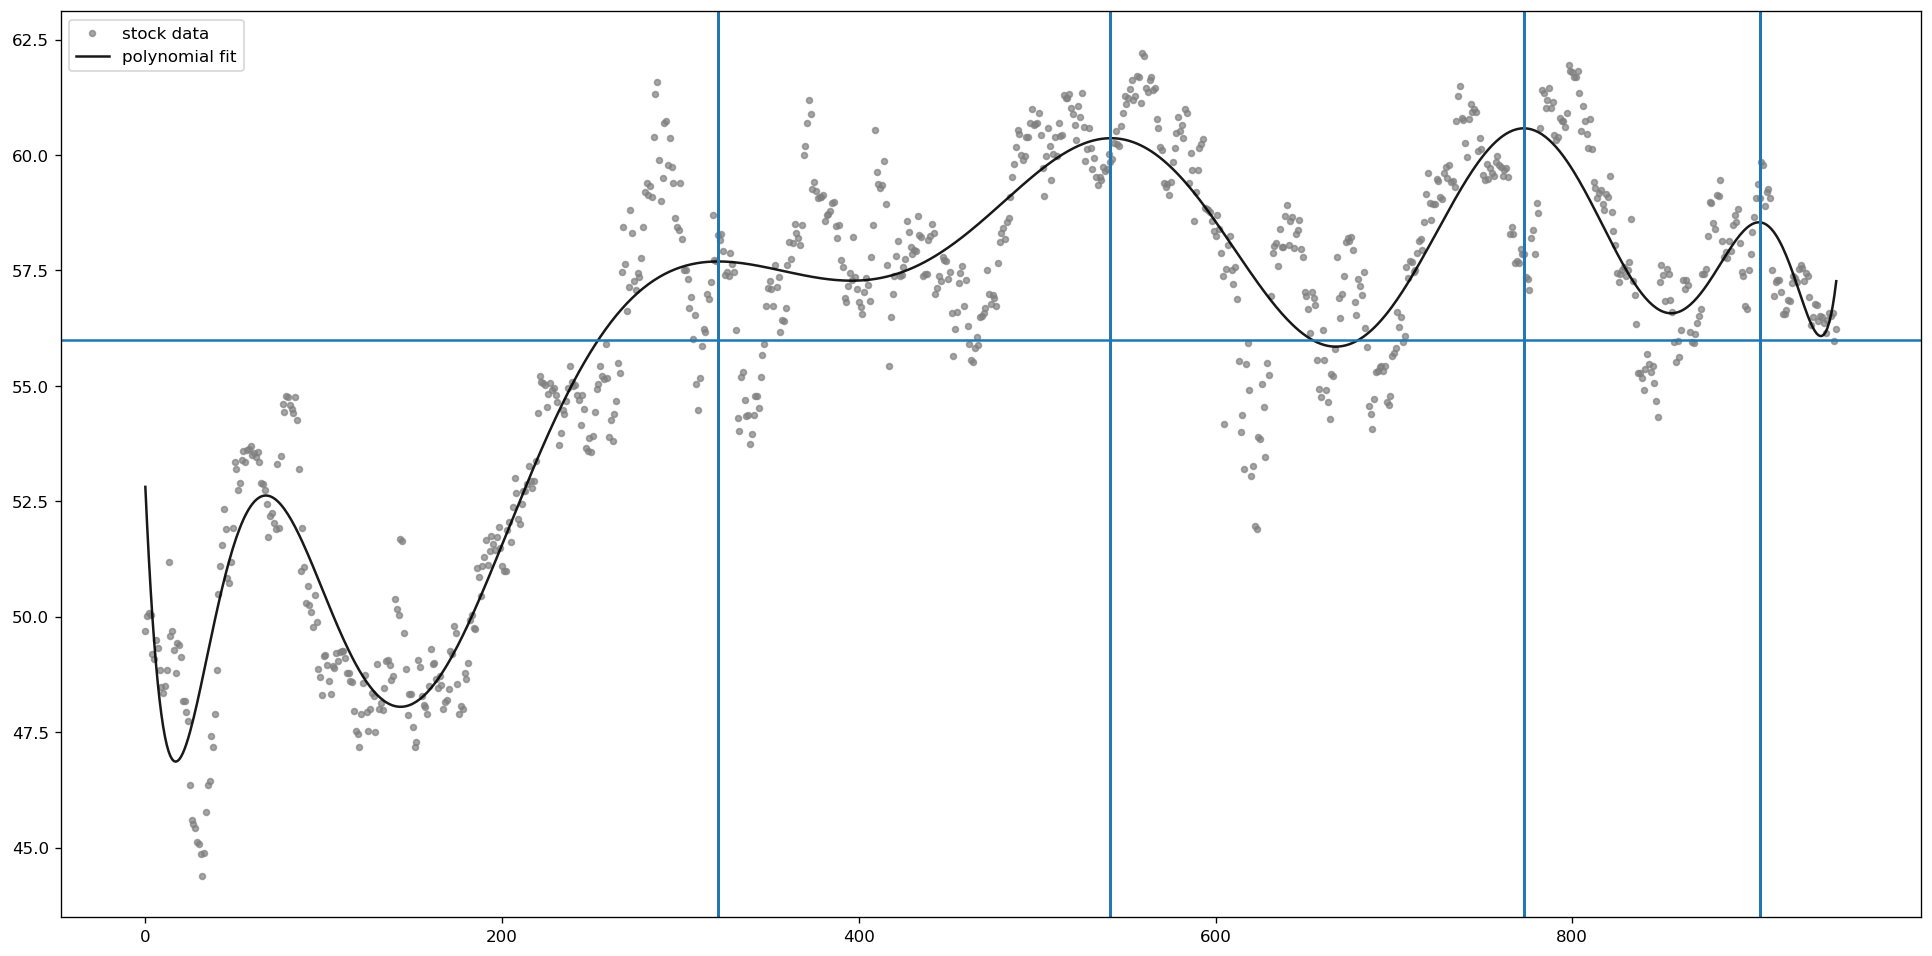

In [10]:
print(y_dict)

# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=3.5, color='grey', alpha=0.7)
# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])

for position in suspected_tops:
    plt.axvline(x=position)

plt.axhline(threshold)    

plt.show()